In [1]:
import sys
refer_path = "D:\\Datasets\\refer-master\\refer-master"
img_path = refer_path+"\\data\\images\\mscoco\\images\\train2014\\"
sys.path.append(refer_path)
from refer import REFER
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pprint import pprint
import csv
import cv2
# IoU function
def computeIoU(box1, box2):
    # each box is of [x1, y1, w, h]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[0]+box1[2]-1, box2[0]+box2[2]-1)
    inter_y2 = min(box1[1]+box1[3]-1, box2[1]+box2[3]-1)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter = (inter_x2-inter_x1+1)*(inter_y2-inter_y1+1)
    else:
        inter = 0
    union = box1[2]*box1[3] + box2[2]*box2[3] - inter
    return float(inter)/union
    
    
data_root = refer_path + '/data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco+'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)


ref_ids = refer.getRefIds()
print(len(ref_ids))
print (len(refer.Imgs))
print (len(refer.imgToRefs))

ref_ids = refer.getRefIds(split='train')
print ('There are %s training referred objects.' % len(ref_ids))

#initialize LSeg
import os
import argparse
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding.datasets import test_batchify_fn 
from encoding.models.sseg import BaseNet
from additional_utils.models import LSeg_MultiEvalModule
from modules.lseg_module import LSegModule

import math
import types
import functools
import torchvision.transforms as torch_transforms
import copy
import itertools
from PIL import Image
import matplotlib.pyplot as plt
import clip
import matplotlib as mpl
import matplotlib.colors as mplc
import matplotlib.figure as mplfigure
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg
from data import get_dataset
import torchvision.transforms as transforms

class Options:
    def __init__(self):
        parser = argparse.ArgumentParser(description="PyTorch Segmentation")
        # model and dataset
        parser.add_argument(
            "--model", type=str, default="encnet", help="model name (default: encnet)"
        )
        parser.add_argument(
            "--backbone",
            type=str,
            default="clip_vitl16_384",
            help="backbone name (default: resnet50)",
        )
        parser.add_argument(
            "--dataset",
            type=str,
            default="ade20k",
            help="dataset name (default: pascal12)",
        )
        parser.add_argument(
            "--workers", type=int, default=16, metavar="N", help="dataloader threads"
        )
        parser.add_argument(
            "--base-size", type=int, default=520, help="base image size"
        )
        parser.add_argument(
            "--crop-size", type=int, default=480, help="crop image size"
        )
        parser.add_argument(
            "--train-split",
            type=str,
            default="train",
            help="dataset train split (default: train)",
        )
        parser.add_argument(
            "--aux", action="store_true", default=False, help="Auxilary Loss"
        )
        parser.add_argument(
            "--se-loss",
            action="store_true",
            default=False,
            help="Semantic Encoding Loss SE-loss",
        )
        parser.add_argument(
            "--se-weight", type=float, default=0.2, help="SE-loss weight (default: 0.2)"
        )
        parser.add_argument(
            "--batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            training (default: auto)",
        )
        parser.add_argument(
            "--test-batch-size",
            type=int,
            default=16,
            metavar="N",
            help="input batch size for \
                            testing (default: same as batch size)",
        )
        # cuda, seed and logging
        parser.add_argument(
            "--no-cuda",
            action="store_true",
            default=False,
            help="disables CUDA training",
        )
        parser.add_argument(
            "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
        )
        # checking point
        parser.add_argument(
            "--weights", type=str, default='', help="checkpoint to test"
        )
        # evaluation option
        parser.add_argument(
            "--eval", action="store_true", default=False, help="evaluating mIoU"
        )
        parser.add_argument(
            "--export",
            type=str,
            default=None,
            help="put the path to resuming file if needed",
        )
        parser.add_argument(
            "--acc-bn",
            action="store_true",
            default=False,
            help="Re-accumulate BN statistics",
        )
        parser.add_argument(
            "--test-val",
            action="store_true",
            default=False,
            help="generate masks on val set",
        )
        parser.add_argument(
            "--no-val",
            action="store_true",
            default=False,
            help="skip validation during training",
        )

        parser.add_argument(
            "--module",
            default='lseg',
            help="select model definition",
        )

        # test option
        parser.add_argument(
            "--data-path", type=str, default='../datasets/', help="path to test image folder"
        )

        parser.add_argument(
            "--no-scaleinv",
            dest="scale_inv",
            default=True,
            action="store_false",
            help="turn off scaleinv layers",
        )

        parser.add_argument(
            "--widehead", default=False, action="store_true", help="wider output head"
        )

        parser.add_argument(
            "--widehead_hr",
            default=False,
            action="store_true",
            help="wider output head",
        )
        parser.add_argument(
            "--ignore_index",
            type=int,
            default=-1,
            help="numeric value of ignore label in gt",
        )
        
        parser.add_argument(
            "--label_src",
            type=str,
            default="default",
            help="how to get the labels",
        )
        
        parser.add_argument(
            "--arch_option",
            type=int,
            default=0,
            help="which kind of architecture to be used",
        )

        parser.add_argument(
            "--block_depth",
            type=int,
            default=0,
            help="how many blocks should be used",
        )

        parser.add_argument(
            "--activation",
            choices=['lrelu', 'tanh'],
            default="lrelu",
            help="use which activation to activate the block",
        )

        self.parser = parser

    def parse(self):
        args = self.parser.parse_args(args=[]) 
        args.cuda = not args.no_cuda and torch.cuda.is_available()
        print(args)
        return args
    


# If image path and f/q is not passed as command
# line arguments, quit and display help message
#if len(sys.argv) < 3:
#    print(__doc__)
#    sys.exit(1)
def ssearch(img_path, bbox, min_size):
    print(min_size)
    rects = []
    # speed-up using multithreads
    cv2.setUseOptimized(True);
    cv2.setNumThreads(4);
    top_left = (bbox[0],bbox[1])
    # read image
    im = cv2.imread(img_path)[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    #cv2.imshow("test", im)
    #print(im)

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)


    #ss.switchToSelectiveSearchQuality()
    ss.switchToSelectiveSearchFast()

    # run selective search segmentation on input image
    temp_rects = ss.process() #xywh
    for rect in temp_rects:
        if boxSize_xywh(rect)>min_size: #remove box if too small
            temp_rect = [0,0,0,0]
            temp_rect[0] = rect[0]+top_left[0]
            temp_rect[1] = rect[1]+top_left[1]
            temp_rect[2] = temp_rect[0]+rect[2]
            temp_rect[3] = temp_rect[1]+rect[3]
            rects.append(temp_rect)
    print('Total Number of Region Proposals: {}'.format(len(rects)))


    # number of region proposals to show
    numShowRects = 100
    # increment to increase/decrease total number
    # of reason proposals to be shown
    increment = 50
    return rects
    
    
def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0]*(n*3)
    for j in range(0,n):
            lab = j
            pallete[j*3+0] = 0
            pallete[j*3+1] = 0
            pallete[j*3+2] = 0
            i = 0
            while (lab > 0):
                    pallete[j*3+0] |= (((lab >> 0) & 1) << (7-i))
                    pallete[j*3+1] |= (((lab >> 1) & 1) << (7-i))
                    pallete[j*3+2] |= (((lab >> 2) & 1) << (7-i))
                    i = i + 1
                    lab >>= 3
    return pallete

def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype('uint8'))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            label = labels[index]
            cur_color = [new_palette[index * 3] / 255.0, new_palette[index * 3 + 1] / 255.0, new_palette[index * 3 + 2] / 255.0]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

#Draw Rectangle on input canvas
def draw_rectangle(draw, coordinates, color, width=1):
    for i in range(width):
        rect_start = (coordinates[0][0] - i, coordinates[0][1] - i)
        rect_end = (coordinates[1][0] + i, coordinates[1][1] + i)
        draw.rectangle((rect_start, rect_end), outline = color)
#Compare if pixel A and B are the same, return true if same
def comparePixel(pxA,pxB):
    for i in range(len(pxA)):
       # print(type(pxA))
       # print(type(pxB))
        if pxA[i] != pxB[i]:
            return False
    return True

#Convert the palette used in lseg into rgba for easier computation
def palette_to_rgba(new_palette):
    colors = [] 
    for i in range(2,len(new_palette),3): #new_pallete is a contiguous tuple of rgb values
        colors.append([new_palette[i-2],new_palette[i-1],new_palette[i]])
    rgba_cols = []
    for color in colors:
        color.append(255)
        rgba_cols.append(np.array(color))
    return rgba_cols #colors of each label for the segmap
#Break the singular segmap into multiple maps for each input label, and generate a single bounding box for each label
#Each generated segmap will have transparency for pixels that are not of the label
def process_segmap(rgba_cols, seg):
    bboxes = []
    segmaps = []

    for rgba_col in rgba_cols:
        test_seg = np.array(seg).copy()
        xmin = ymin = 99999
        xmax = ymax = 0
        #separate the segments, put in a larger loop for each label
        for col in range(0,len(test_seg)):
            #print(row)
            for row in range(0,len(test_seg[col])):
                if not comparePixel(test_seg[col][row],rgba_col):
                    test_seg[col][row] = [0,0,0,0] #make transparent
                else: #get top left and bottom right to draw rectangle
                    if row>xmax:
                        xmax = row
                    if col>ymax:
                        ymax = col
                    if row<xmin:
                        xmin = row
                    if col<ymin:
                        ymin = col
        bboxes.append([xmin,ymin,xmax,ymax])
        segmaps.append(test_seg)
    return bboxes, segmaps
    #Image.fromarray(test_seg)
    
#Function to find the gap within the existing bounding box
#Returns 2 arrays indicating the range or horizontal gap and vertical gap
#Values in the array can be used to identify how to split the bounding boxes
#Eg. Return value [sx1,sx2] indicates the split starts from x=sx1, y=y and ends at x=sx2, y=y

def contiguous_transparency_scan(box,segmap,instance_threshold=0):
    #iterative vertical scan (left to right scan every column)
    min_x = max_x = -1
    for x in range(box[0],box[2]):
        isContiguous = True #whether it is a contiguous transparent block
        count_colored = 0
        for y in range(box[1],box[3]):
            #print(x,y)
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>instance_threshold:
                    isContiguous = False
                    break
        if isContiguous:
            #print(x)
            if min_x==-1:
                min_x = x
                max_x = min_x
            else:
                max_x +=1
        else:
            if max_x - min_x > 0:
                break
    #iterative horizontal scan (top to bottom scan every row)
    min_y = max_y = -1
    for y in range(box[1],box[3]):
        isContiguous = True
        count_colored = 0
        for x in range(box[0],box[2]):
            if not comparePixel(segmap[y][x],[0,0,0,0]):
                count_colored+=1
                if count_colored>=instance_threshold:
                    isContiguous = False
                    break
                #isContiguous = False
                #break
        if isContiguous:
            if min_y==-1:
                min_y = y
                max_y = min_y
            else:
                max_y +=1
        else:
            if max_y - min_y > 0:
                break
    #if max_x - min_x>0 or arbitary threshold means there is a gap in the segmentation
    # if the above is true, that means the bounding box can be instanced into a left and right instance
    # if max_y - min_y >0 or arbitary threshold, means thee boundingbox can be instanced into a top and bottom instance
    return [min_x,max_x],[min_y,max_y]

#Optimize the new boxes to fit nicely around the segment instance, split bounding boxes tend to be larger than segment
def optimizeBoxes(bbox,segmap):
    new_boxes = []

    for box in bbox:
        xmin = ymin = 99999
        xmax = ymax = 0
        for col in range(box[0],box[2]):
            for row in range(box[1],box[3]):
                if not comparePixel(segmap[row][col], [0,0,0,0]):
                    if col>xmax:
                        xmax = col
                    if row>ymax:
                        ymax = row
                    if col<xmin:
                        xmin = col
                    if row<ymin:
                        ymin = row
        if [xmin,ymin,xmax,ymax] != [99999,99999,0,0]:
            new_boxes.append([xmin,ymin,xmax,ymax])
        else:
            new_boxes.append(box)

    return new_boxes

#Split boxes and optimize
def splitBox(box,x_split, y_split, segmap):
    bbox = []
    if x_split[0]==-1 and y_split[0]==-1:
        return
    elif x_split[0]==-1:
        #splt top and bottom
        top_box = [box[0],y_split[0],box[2],box[3]]
        bot_box = [box[0],box[1],box[2],y_split[1]]
        #bbox = [top_box,bot_box]
        bbox = optimizeBoxes([top_box,bot_box],segmap)
    else:
        #split left and right
        left_box = [box[0],box[1],x_split[0],box[3]]
        right_box = [x_split[1],box[1],box[2],box[3]]
        #bbox = [left_box,right_box]
        bbox = optimizeBoxes([left_box,right_box],segmap)
    return bbox
    
#Return box size in area
def boxSize(box):
    x = box[2]-box[0]
    y = box[3]-box[1]
    return x*y

def boxSize_xywh(box):
    return box[2]*box[3]
    
#Return max similarity value for each variable
def boxSimilarity(box1,box2):
    x1 = abs(box2[0]-box1[0])
    y1 = abs(box2[1]-box1[1])
    x2 = abs(box2[2]-box1[2])
    y2 = abs(box2[3]-box1[3])
    return max([x1,y1,x2,y2])
    
#Main function to instance the segmentation map based on horizontal and verticle gaps, as well as optimize the size
#boxes that are too similar or too small are also filtered out along the way
def bbox_instancing(bboxes,segmaps,min_size = 5):
    final_instances = []
    for idx in range(len(bboxes)): #number of classes
        box = bboxes[idx]
        segmap = segmaps[idx]

        box_instances = []
        instanced_boxes = [box]
        i = 0
        #iteratively instance boxes repeatedly until boxes cannot be instanced further
        while(i<len(instanced_boxes)):
            x_contiguous,y_contiguous = contiguous_transparency_scan(instanced_boxes[i],segmap,instance_threshold=0)
            #x_contiguous,y_contiguous = segmap_instancing(instanced_boxes[i],segmap,instance_threshold=0)
            #print (x_contiguous)
            new_bboxes = splitBox(instanced_boxes[i],x_contiguous,y_contiguous,segmap)
            #print(new_bboxes)
            if new_bboxes != None:
                new_count = 0
                instanced_boxes.pop(i) #remove the box that got split into 2 instances first
                i-=1
                for new_box in new_bboxes:
                    #append the instances only if it meets the minimum size requirement
                    if boxSize(new_box)>min_size:
                        instanced_boxes.append(new_box)
                        new_count+=1
                #if new_count>0: #if at least one new box is added

            i+=1
        #filter out similar boxes that are adjacent
        i=0
        while(i<len(instanced_boxes)-1):

            sim = boxSimilarity(instanced_boxes[i],instanced_boxes[i+1])
            if (sim<5): #too similar
                #print(instanced_boxes[i],instanced_boxes[i+1])
                # remove smaller box
                if boxSize(instanced_boxes[i])>boxSize(instanced_boxes[i+1]):
                    instanced_boxes.pop(i+1)
                else:
                    instanced_boxes.pop(i)
                i-=1
            i+=1
        final_instances.append(instanced_boxes)
    return final_instances
    
args = Options().parse()

torch.manual_seed(args.seed)
args.test_batch_size = 1 
alpha=0.5
    
args.scale_inv = False
args.widehead = True
args.dataset = 'ade20k'
args.backbone = 'clip_vitl16_384'
args.weights = 'checkpoints/demo_e200.ckpt'
args.ignore_index = 255

module = LSegModule.load_from_checkpoint(
    checkpoint_path=args.weights,
    data_path=args.data_path,
    dataset=args.dataset,
    backbone=args.backbone,
    aux=args.aux,
    num_features=256,
    aux_weight=0,
    se_loss=False,
    se_weight=0,
    base_lr=0,
    batch_size=1,
    max_epochs=0,
    ignore_index=args.ignore_index,
    dropout=0.0,
    scale_inv=args.scale_inv,
    augment=False,
    no_batchnorm=False,
    widehead=args.widehead,
    widehead_hr=args.widehead_hr,
    map_locatin="cpu",
    arch_option=0,
    block_depth=0,
    activation='lrelu',
)

input_transform = module.val_transform

# dataloader
loader_kwargs = (
    {"num_workers": args.workers, "pin_memory": True} if args.cuda else {}
)

# model
if isinstance(module.net, BaseNet):
    model = module.net
else:
    model = module
    
model = model.eval()
model = model.cpu()
scales = (
    [0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]
    if args.dataset == "citys"
    else [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
)  

model.mean = [0.5, 0.5, 0.5]
model.std = [0.5, 0.5, 0.5]

evaluator = LSeg_MultiEvalModule(
    model, scales=scales, flip=True
).cuda()
evaluator.eval()



#initialize CLIP

import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

counter = 0
checkpoint = 0 # enter last index in iou log

#loop

loading dataset refcoco+ into memory...
creating index...
index created.
done
49856
19992
19992
There are 42278 training referred objects.


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(acc_bn=False, activation='lrelu', arch_option=0, aux=False, backbone='clip_vitl16_384', base_size=520, batch_size=16, block_depth=0, crop_size=480, cuda=True, data_path='../datasets/', dataset='ade20k', eval=False, export=None, ignore_index=-1, label_src='default', model='encnet', module='lseg', no_cuda=False, no_val=False, scale_inv=True, se_loss=False, se_weight=0.2, seed=1, test_batch_size=16, test_val=False, train_split='train', weights='', widehead=False, widehead_hr=False, workers=16)
** Use norm [0.5, 0.5, 0.5], [0.5, 0.5, 0.5] as the mean and std **
{'base_size': 520, 'crop_size': 480}
train
BaseDataset: base_size 520, crop_size 480
len(img_paths): 20210
val


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\deprecate\deprecation.py:115: LightningDeprecationWarning: The `Accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.classification.accuracy.Accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


MultiEvalModule: base_size 520, crop_size 480


In [2]:
ref_id = ref_ids[32]
#if counter<=(checkpoint+2): #somehow need to add +2 to checkpoint to resume
#    counter+=1
#    continue
ref = refer.loadRefs(ref_id)[0]
image_id = refer.getImgIds(ref_id)[0]
#if len(ref['sentences']) < 2:
#    continue

pprint(ref)
print ('LSeg label %s.' % refer.Cats[ref['category_id']]) #pass to lseg
args.label_src = refer.Cats[ref['category_id']] + ",others"

{'ann_id': 531973,
 'category_id': 1,
 'file_name': 'COCO_train2014_000000581425_1.jpg',
 'image_id': 581425,
 'ref_id': 36,
 'sent_ids': [102, 103, 104],
 'sentences': [{'raw': 'green shirt',
                'sent': 'green shirt',
                'sent_id': 102,
                'tokens': ['green', 'shirt']},
               {'raw': 'green shirt',
                'sent': 'green shirt',
                'sent_id': 103,
                'tokens': ['green', 'shirt']},
               {'raw': 'pirate on the cake',
                'sent': 'pirate on the cake',
                'sent_id': 104,
                'tokens': ['pirate', 'on', 'the', 'cake']}],
 'split': 'train'}
LSeg label person.


** Input label value: person,others **
** MultiEvalModule parallel_forward phase: ['person', 'others'] **
** MultiEvalModule forward phase: ['person', 'others'] **


C:\Users\bater\anaconda3\envs\lseg37\lib\site-packages\torch\nn\functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Box 0: 0.04208
Box 1: 0.006798
Box 0: 0.04208
Box 1: 0.006798
Box 0: 0.008316
Box 1: 0.996


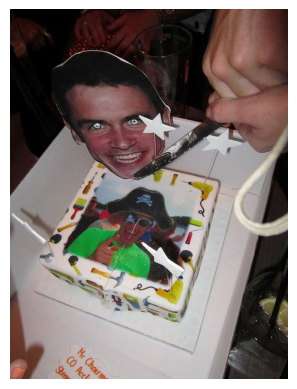

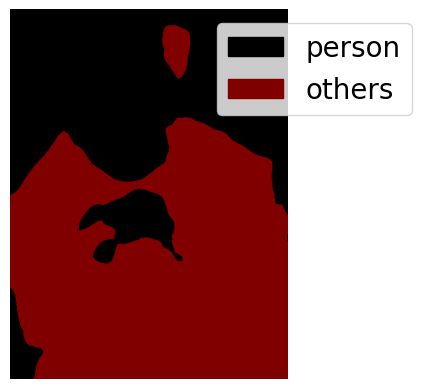

In [3]:

#LSEG Running
labels = []
print('** Input label value: {} **'.format(args.label_src))
lines = args.label_src.split(',')
for line in lines:
    label = line
    labels.append(label)
#labels.append("others")

#try:
#load image
#crop_size = 480
padding = [0.0] * 3
image = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#plt.imshow(image)
image = np.array(image)
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)
image = transform(image).unsqueeze(0)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
#plt.imshow(img)


with torch.no_grad():
    outputs = evaluator.parallel_forward(image, labels) #evaluator.forward(image, labels) #parallel_forward
    #outputs = model(image,labels)
    predicts = [
        torch.max(output, 1)[1].cpu().numpy() 
        for output in outputs
    ]
#Lseg results    
predict = predicts[0]

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(predict, new_palette, out_label_flag=True, labels=labels)
img = image[0].permute(1,2,0)
img = img * 0.5 + 0.5
img = Image.fromarray(np.uint8(255*img)).convert("RGBA")
seg = mask.convert("RGBA")
out = Image.blend(img, seg, alpha)
plt.axis('off')
plt.imshow(img)
plt.figure()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
plt.axis('off')
plt.imshow(seg)

#get bbox
rgba_cols = palette_to_rgba(new_palette)
bboxes, segmaps = process_segmap(rgba_cols,seg)

#Show results of bounding boxes
from PIL import Image, ImageDraw
img_copy = img.copy()
#for i in range(0,len(bboxes)-1):
#    topLeft = (bboxes[i][0],bboxes[i][1])
#    bottomRight = (bboxes[i][2],bboxes[i][3])
#    img1 = ImageDraw.Draw(img_copy)
#    rect_color = getHexColor(rgba_cols[i])
#    draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[i]), width=5)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy)

w,h = img.size
min_size = w*h*0.005 #arbitary min size, 0.005 for the cat human image
new_bbox = bbox_instancing(bboxes,segmaps,min_size=min_size) 

#sample bbox instancing result
img_copy_test = img.copy()
for i in range(len(new_bbox)-1):
    for j in range(len(new_bbox[i])):
        topLeft = (new_bbox[i][j][0],new_bbox[i][j][1])
        bottomRight = (new_bbox[i][j][2],new_bbox[i][j][3])
        img1 = ImageDraw.Draw(img_copy_test)
        #rect_color = getHexColor(rgba_cols[i])
        draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=5)
        #draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#plt.axis('off')
#plt.imshow(img_copy_test)
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
img_copy_clip = np.array(img_copy_clip)
cropped_imgs = []
for class_bbox in new_bbox:
    cropped_imgs.append([])
    for bbox in class_bbox:
        cropped_imgs[len(cropped_imgs)-1].append(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]])



for cls in cropped_imgs:
    for i in range(len(cls)):
        #img_transform = transform(cls[i]).unsqueeze(0)
        #print(cls[i])
        cls[i]=Image.fromarray(cls[i])


vote_arr = [0]*len(new_bbox[0])

for sentence in ref['sentences']:          
    max_score = 0
    best_id = -1
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    vote_arr[best_id]+=max_score

#print(vote_arr)
best_bbox = vote_arr.index(max(vote_arr)) #narrow down 1 box in the instance first, then use region proposal within that box

In [32]:
vote_arr

[0.08416748046875, 0.99609375]

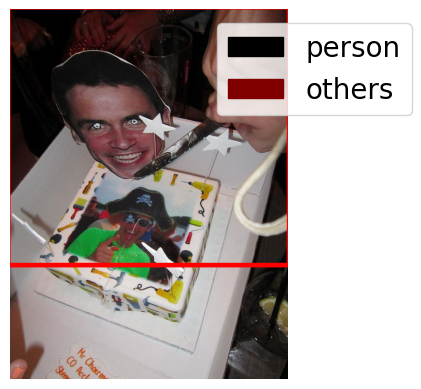

In [4]:
#draw results from clip
from PIL import Image, ImageDraw
img_copy_test2 = img.copy()
#print("clip retval: " + str(best_bbox))
#print((processed_new_bbox[i][j]))
topLeft = (new_bbox[0][best_bbox][0],new_bbox[0][best_bbox][1])
bottomRight = (new_bbox[0][best_bbox][2],new_bbox[0][best_bbox][3])
img2 = ImageDraw.Draw(img_copy_test2)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft,bottomRight),color = "red", width=8)
new_bbox_xywh = [topLeft[0], topLeft[1], bottomRight[0]-topLeft[0], bottomRight[1]-topLeft[1]]
#ref_bbox = refer.refToAnn[ref_id]['bbox']
#IoU = computeIoU(ref_bbox, new_bbox_xywh)
#print("IoU:"+str(IoU))
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test2)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})

In [5]:
#####REGION PROPOSAL########

prop_rects = ssearch(img_path+refer.loadImgs(image_id)[0]['file_name'], new_bbox[0][best_bbox], min_size) #uninstanced bboxes, use the best box and perform region proposal
img_copy_test = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(prop_rects)
count = 0

best_bbox = -1

padding = [0.0] * 3
img_copy_clip = Image.open(img_path+refer.loadImgs(image_id)[0]['file_name'])
#print(type(img_copy_clip))
img_copy_clip = np.array(img_copy_clip)

cropped_imgs = [[]]


for bbox in prop_rects:
    #print(bbox)
    cropped_imgs[0].append(Image.fromarray(img_copy_clip[bbox[1]:bbox[3],bbox[0]:bbox[2]]))


vote_arr = []

best_id = -1


3072.0
Total Number of Region Proposals: 921


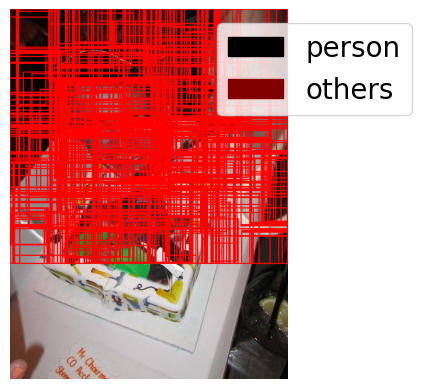

In [6]:

for rect in prop_rects:
    #print((processed_new_bbox[i][j]))
    topLeft = (rect[0],rect[1])
    bottomRight = (rect[2],rect[3])
    img1 = ImageDraw.Draw(img_copy_test)
    #rect_color = getHexColor(rgba_cols[i])
    #draw_rectangle(img1, (topLeft,bottomRight),color = tuple(rgba_cols[0]), width=5)
    draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
    count+=1
    if count>1000:
        break
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#print("Input: "+user_input)
#bboxes

In [7]:
for sentence in ref['sentences']:          
    max_score = 0
    ret_index_temp = []
    ret_index_cls = []
    #print("number of cropped: "+ str(len(cropped_imgs[0])))
    for j in range(len(cropped_imgs[0])): #for each cropped_image run it through clip with the label of description and get the highest scoring boxes
        #print(j)
        #image = preprocess(Image.open("CLIP.png")).unsqueeze(0).to(device)
        image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
        #text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
        text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

            logits_per_image, logits_per_text = model(image, text)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()

        print("Box "+str(j)+": "+str(probs[0][0]))
        #if score is higher than max, max = score and append to list. if score within 0.1 of max score, append as well
        if probs[0][0]>max_score:
            max_score = probs[0][0]
            best_id = j
    if best_id not in vote_arr:
        vote_arr.append(best_id)
    #else:
    #    break


Box 0: 0.8105
Box 1: 0.03021
Box 2: 0.00819
Box 3: 0.03906
Box 4: 0.01428
Box 5: 0.005386
Box 6: 0.154
Box 7: 0.0326
Box 8: 0.01854
Box 9: 0.1779
Box 10: 0.01854
Box 11: 0.3887
Box 12: 0.852
Box 13: 0.002253
Box 14: 0.01692
Box 15: 0.0379
Box 16: 0.01883
Box 17: 0.03732
Box 18: 0.004906
Box 19: 0.0637
Box 20: 0.0006986
Box 21: 0.0888
Box 22: 0.003027
Box 23: 0.002493
Box 24: 0.01033
Box 25: 0.0637
Box 26: 0.02194
Box 27: 0.01883
Box 28: 0.02931
Box 29: 0.01033
Box 30: 0.0336
Box 31: 0.01883
Box 32: 0.02887
Box 33: 0.01854
Box 34: 0.003944
Box 35: 0.001525
Box 36: 0.08386
Box 37: 0.958
Box 38: 0.01666
Box 39: 0.001206
Box 40: 0.304
Box 41: 0.011505
Box 42: 0.00582
Box 43: 0.007233
Box 44: 0.01302
Box 45: 0.007122
Box 46: 0.0346
Box 47: 0.01049
Box 48: 0.003593
Box 49: 0.959
Box 50: 0.000732
Box 51: 0.001897
Box 52: 0.0542
Box 53: 0.254
Box 54: 0.0237
Box 55: 0.3008
Box 56: 0.734
Box 57: 0.0159
Box 58: 0.01116
Box 59: 0.6895
Box 60: 0.0851
Box 61: 0.3074
Box 62: 0.01187
Box 63: 0.01519
B

Box 493: 0.004433
Box 494: 0.02002
Box 495: 0.00573
Box 496: 0.1824
Box 497: 0.04272
Box 498: 0.01033
Box 499: 0.002398
Box 500: 0.00202
Box 501: 0.1009
Box 502: 0.006798
Box 503: 0.01302
Box 504: 0.011505
Box 505: 0.4111
Box 506: 0.2043
Box 507: 0.0628
Box 508: 0.003376
Box 509: 0.01033
Box 510: 0.00669
Box 511: 0.01692
Box 512: 0.01082
Box 513: 0.01692
Box 514: 0.012054
Box 515: 0.0159
Box 516: 0.003075
Box 517: 0.02759
Box 518: 0.0223
Box 519: 0.003483
Box 520: 0.00619
Box 521: 0.0042
Box 522: 0.00986
Box 523: 0.00522
Box 524: 0.01001
Box 525: 0.04208
Box 526: 0.01169
Box 527: 0.01099
Box 528: 0.008316
Box 529: 0.00514
Box 530: 0.02596
Box 531: 0.01343
Box 532: 0.3667
Box 533: 0.003824
Box 534: 0.003824
Box 535: 0.0628
Box 536: 0.01082
Box 537: 0.003172
Box 538: 0.005913
Box 539: 0.006905
Box 540: 0.000883
Box 541: 0.02097
Box 542: 0.001782
Box 543: 0.008064
Box 544: 0.0164
Box 545: 0.00479
Box 546: 0.00654
Box 547: 0.00639
Box 548: 0.2815
Box 549: 0.00899
Box 550: 0.0575
Box 551: 0

Box 66: 0.1824
Box 67: 0.01519
Box 68: 0.1779
Box 69: 0.0336
Box 70: 0.01616
Box 71: 0.1225
Box 72: 0.06097
Box 73: 0.0914
Box 74: 0.06464
Box 75: 0.007576
Box 76: 0.0031
Box 77: 0.003593
Box 78: 0.2422
Box 79: 0.02162
Box 80: 0.012054
Box 81: 0.1192
Box 82: 0.003765
Box 83: 0.003885
Box 84: 0.03906
Box 85: 0.658
Box 86: 0.1624
Box 87: 0.0042
Box 88: 0.00986
Box 89: 0.02887
Box 90: 0.1366
Box 91: 0.002867
Box 92: 0.1666
Box 93: 0.731
Box 94: 0.094
Box 95: 0.01744
Box 96: 0.0628
Box 97: 0.0237
Box 98: 0.0827
Box 99: 0.03906
Box 100: 0.044
Box 101: 0.89
Box 102: 0.02097
Box 103: 0.01826
Box 104: 0.03622
Box 105: 0.02443
Box 106: 0.00819
Box 107: 0.12085
Box 108: 0.01187
Box 109: 0.01017
Box 110: 0.2366
Box 111: 0.002472
Box 112: 0.0827
Box 113: 0.03308
Box 114: 0.0863
Box 115: 0.02162
Box 116: 0.002758
Box 117: 0.006004
Box 118: 0.00202
Box 119: 0.03162
Box 120: 0.1052
Box 121: 0.01243
Box 122: 0.04672
Box 123: 0.1144
Box 124: 0.00054
Box 125: 0.0542
Box 126: 0.001585
Box 127: 0.154
Box 

Box 552: 0.2147
Box 553: 0.0967
Box 554: 0.03516
Box 555: 0.01772
Box 556: 0.03162
Box 557: 0.005642
Box 558: 0.0248
Box 559: 0.00746
Box 560: 0.1082
Box 561: 0.001926
Box 562: 0.00629
Box 563: 0.02443
Box 564: 0.003593
Box 565: 0.001356
Box 566: 0.04468
Box 567: 0.01169
Box 568: 0.0006514
Box 569: 0.5156
Box 570: 0.03906
Box 571: 0.596
Box 572: 0.006798
Box 573: 0.000738
Box 574: 0.0017
Box 575: 0.0336
Box 576: 0.0248
Box 577: 0.0716
Box 578: 0.00468
Box 579: 0.012825
Box 580: 0.02759
Box 581: 0.04025
Box 582: 0.02635
Box 583: 0.002253
Box 584: 0.01971
Box 585: 0.000993
Box 586: 0.02129
Box 587: 0.01169
Box 588: 0.00255
Box 589: 0.231
Box 590: 0.02759
Box 591: 0.00255
Box 592: 0.01169
Box 593: 0.04468
Box 594: 0.06854
Box 595: 0.02556
Box 596: 0.00433
Box 597: 0.212
Box 598: 0.1824
Box 599: 0.01942
Box 600: 0.0336
Box 601: 0.006744
Box 602: 0.0326
Box 603: 0.01302
Box 604: 0.01971
Box 605: 0.8706
Box 606: 0.01033
Box 607: 0.001636
Box 608: 0.03845
Box 609: 0.04337
Box 610: 0.562
Box 6

Box 129: 0.01224
Box 130: 0.0619
Box 131: 0.543
Box 132: 0.001675
Box 133: 0.78
Box 134: 0.2147
Box 135: 0.01243
Box 136: 0.00639
Box 137: 0.1896
Box 138: 0.06757
Box 139: 0.01971
Box 140: 0.04025
Box 141: 0.9326
Box 142: 0.9785
Box 143: 0.02162
Box 144: 0.03021
Box 145: 0.08154
Box 146: 0.9927
Box 147: 0.0379
Box 148: 0.05582
Box 149: 0.01495
Box 150: 0.3738
Box 151: 0.3276
Box 152: 0.2451
Box 153: 0.9663
Box 154: 0.5737
Box 155: 0.899
Box 156: 0.01033
Box 157: 0.02065
Box 158: 0.854
Box 159: 0.8374
Box 160: 0.01385
Box 161: 0.0002491
Box 162: 0.858
Box 163: 0.1312
Box 164: 0.9976
Box 165: 0.999
Box 166: 0.00483
Box 167: 0.03677
Box 168: 0.005062
Box 169: 0.152
Box 170: 0.0575
Box 171: 0.3108
Box 172: 0.01428
Box 173: 0.01049
Box 174: 0.01116
Box 175: 0.9355
Box 176: 0.1023
Box 177: 0.001169
Box 178: 0.07806
Box 179: 0.0145
Box 180: 0.01883
Box 181: 0.01567
Box 182: 0.01495
Box 183: 0.84
Box 184: 0.999
Box 185: 0.4226
Box 186: 0.009125
Box 187: 0.983
Box 188: 0.993
Box 189: 0.4727
Box

Box 635: 0.1404
Box 636: 0.2659
Box 637: 0.002115
Box 638: 0.00746
Box 639: 0.01302
Box 640: 0.11127
Box 641: 0.981
Box 642: 0.3416
Box 643: 0.04602
Box 644: 0.9136
Box 645: 0.6895
Box 646: 0.8857
Box 647: 0.3242
Box 648: 0.2173
Box 649: 0.01243
Box 650: 0.4648
Box 651: 0.02975
Box 652: 0.915
Box 653: 0.02596
Box 654: 0.669
Box 655: 0.1442
Box 656: 0.997
Box 657: 0.04813
Box 658: 0.005386
Box 659: 0.314
Box 660: 0.02194
Box 661: 0.4036
Box 662: 0.929
Box 663: 0.03845
Box 664: 0.63
Box 665: 0.9995
Box 666: 1.0
Box 667: 0.997
Box 668: 0.831
Box 669: 0.2366
Box 670: 0.007694
Box 671: 1.0
Box 672: 0.911
Box 673: 0.999
Box 674: 1.0
Box 675: 1.0
Box 676: 0.9346
Box 677: 0.0248
Box 678: 0.9956
Box 679: 0.385
Box 680: 0.002253
Box 681: 0.04672
Box 682: 0.4226
Box 683: 0.1082
Box 684: 0.02263
Box 685: 0.8457
Box 686: 0.983
Box 687: 0.785
Box 688: 0.1144
Box 689: 0.1242
Box 690: 0.006096
Box 691: 0.7188
Box 692: 0.558
Box 693: 0.007935
Box 694: 0.03964
Box 695: 0.999
Box 696: 0.04742
Box 697: 0.

In [8]:
vote_arr
#best_id = 585

[292, 98]

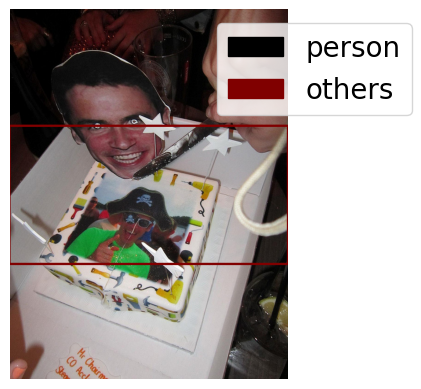

In [9]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

#idx = best_id
#print((processed_new_bbox[i][j]))
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

for box_id in vote_arr:
    #print(prop_rects[box_id])
    if prop_rects[box_id][0]<topLeft_new[0]:
        topLeft_new[0] = prop_rects[box_id][0]
    if prop_rects[box_id][1]<topLeft_new[1]:
        topLeft_new[1] = prop_rects[box_id][1]
    if prop_rects[box_id][2]>botRight_new[0]:
        botRight_new[0] = prop_rects[box_id][2]
    if prop_rects[box_id][3]>botRight_new[1]:
        botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

1. green shirt
2. green shirt
3. pirate on the cake


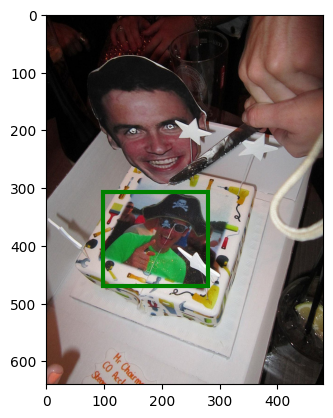

In [10]:
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

In [11]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.20418647952739838

In [38]:
j = 15
image = preprocess(cropped_imgs[0][j]).unsqueeze(0).to(device)
#text = clip.tokenize(["person in blue", "person in white", "person in red"]).to(device)
text = clip.tokenize([sentence['sent'], "other"]).to(device)  #extracted input is also based on class
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#print("Box "+str(j)+": "+str(probs[0][0]))
probs

array([[8.56e-04, 9.99e-01]], dtype=float16)

In [39]:
topLeft_new = [99999999,9999999]
botRight_new = [-1,-1]

box_id = j
#print(prop_rects[box_id])
if prop_rects[box_id][0]<topLeft_new[0]:
    topLeft_new[0] = prop_rects[box_id][0]
if prop_rects[box_id][1]<topLeft_new[1]:
    topLeft_new[1] = prop_rects[box_id][1]
if prop_rects[box_id][2]>botRight_new[0]:
    botRight_new[0] = prop_rects[box_id][2]
if prop_rects[box_id][3]>botRight_new[1]:
    botRight_new[1] = prop_rects[box_id][3]
final_bbox = [topLeft_new[0], topLeft_new[1], botRight_new[0],botRight_new[1]]
final_bbox

[338, 0, 478, 247]

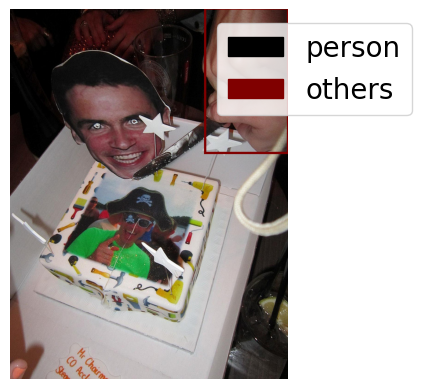

In [40]:
from PIL import Image, ImageDraw
img_copy_test = img.copy()

idx = best_id
#print((processed_new_bbox[i][j]))
#topLeft = (prop_rects[idx][0],prop_rects[idx][1])
#bottomRight = (prop_rects[idx][2],prop_rects[idx][3])
img2 = ImageDraw.Draw(img_copy_test)
#rect_color = getHexColor(rgba_cols[i])
draw_rectangle(img2, (topLeft_new,botRight_new),color = tuple(rgba_cols[i]), width=4)
#draw_rectangle(img1, (topLeft,bottomRight),color = "red", width=2)
plt.axis('off')
plt.imshow(img_copy_test)
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), prop={'size': 20})
#**TODO** IOU, remember to check for size difference
#plt.figure()
#refer.showRef(ref, seg_box='box')
#plt.show()

In [37]:
new_bbox_xywh = [topLeft_new[0], topLeft_new[1], botRight_new[0]-topLeft_new[0], botRight_new[1]-topLeft_new[1]]
ref_bbox = refer.refToAnn[ref_id]['bbox']
IoU = computeIoU(ref_bbox, new_bbox_xywh)
IoU

0.0